In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
%matplotlib inline
from matplotlib.ticker import FuncFormatter
plt.style.use('fivethirtyeight')

import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import VarianceThreshold, chi2
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, plot_det_curve, classification_report, precision_recall_fscore_support, accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, plot_roc_curve
from sklearn.tree import plot_tree

from yellowbrick.classifier import ROCAUC, ClassificationReport, ConfusionMatrix
from yellowbrick.style import set_palette
from yellowbrick.model_selection import FeatureImportances, ValidationCurve, RFECV, DroppingCurve
from yellowbrick.features import radviz, RadViz, Manifold, PCA, JointPlotVisualizer, ParallelCoordinates
from yellowbrick.style.palettes import SEQUENCES, color_palette
from yellowbrick.target import FeatureCorrelation

import re

from string import punctuation

from tempfile import mkdtemp

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from skmultilearn.model_selection import iterative_train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/audreygilbreath/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### **Load the data**

In [2]:
df = pd.read_csv('cards.csv')
df1 = pd.read_csv('cards.csv')

In [3]:
df.head()

,index,id,artist,asciiName,availability,boosterTypes,borderColor,cardKingdomEtchedId,cardKingdomFoilId,cardKingdomId,...,supertypes,tcgplayerEtchedProductId,tcgplayerProductId,text,toughness,type,types,uuid,variations,watermark
0,0,1,Pete Venters,NaN,"mtgo,paper",draft,black,NaN,NaN,122719.0,...,NaN,NaN,15032.0,First strike (This creature deals combat damag...,4,Creature — Human Cleric,Creature,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,b7c19924-b4bf-56fc-aa73-f586e940bd42,NaN
1,1,2,Pete Venters,NaN,"mtgo,paper",draft,black,NaN,123087.0,NaN,...,NaN,NaN,15032.0,First strike (This creature deals combat damag...,4,Creature — Human Cleric,Creature,b7c19924-b4bf-56fc-aa73-f586e940bd42,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,NaN
2,2,3,Volkan Baǵa,NaN,"mtgo,paper",draft,black,NaN,NaN,122720.0,...,NaN,NaN,15033.0,Flying\nWhen Angel of Mercy enters the battlef...,3,Creature — Angel,Creature,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,NaN
3,3,4,Volkan Baǵa,NaN,"mtgo,paper",draft,black,NaN,123088.0,NaN,...,NaN,NaN,15033.0,Flying\nWhen Angel of Mercy enters the battlef...,3,Creature — Angel,Creature,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,NaN
4,4,5,Mark Zug,NaN,"mtgo,paper",draft,black,NaN,NaN,122721.0,...,NaN,NaN,15035.0,Target creature gets +3/+3 and gains flying un...,NaN,Sorcery,Sorcery,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,c5655330-5131-5f40-9d3e-0549d88c6e9e,NaN


The dataframe contains data on every card printed in every set. Each row represents a card within a set (Note: this means the dataframe included reprints).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69315 entries, 0 to 69314
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     69315 non-null  int64  
 1   id                        69315 non-null  int64  
 2   artist                    69303 non-null  object 
 3   asciiName                 68 non-null     object 
 4   availability              69314 non-null  object 
 5   boosterTypes              41835 non-null  object 
 6   borderColor               69315 non-null  object 
 7   cardKingdomEtchedId       694 non-null    float64
 8   cardKingdomFoilId         35787 non-null  float64
 9   cardKingdomId             52909 non-null  float64
 10  cardParts                 9 non-null      object 
 11  cardsphereId              56713 non-null  float64
 12  colorIdentity             62064 non-null  object 
 13  colorIndicator            530 non-null    object 
 14  colors

The dataframe has 69,315 rows and 89 columns.   
There are several columns with missing values, some of them missing only a few values and some of them containing almost all NaN values. I will use this information as a factor to help me determine if a column should be dropped or not.

In [5]:
df.describe()

,index,id,cardKingdomEtchedId,cardKingdomFoilId,cardKingdomId,cardsphereId,convertedManaCost,edhrecRank,faceConvertedManaCost,faceManaValue,...,life,manaValue,mcmId,mcmMetaId,mtgArenaId,mtgoFoilId,mtgoId,multiverseId,tcgplayerEtchedProductId,tcgplayerProductId
count,69315.000000,69315.000000,694.000000,35787.000000,52909.000000,56713.000000,69315.000000,63421.000000,1808.000000,1808.000000,...,119.000000,69315.000000,60497.000000,44869.000000,9405.000000,24377.000000,37867.000000,49081.000000,706.000000,60658.000000
mean,34657.000000,34658.000000,251557.221902,187145.261603,174110.345952,44377.559819,31.835771,9205.192192,2.143805,2.143805,...,1.084034,31.835771,275018.726862,123220.173015,73441.178628,36914.270460,51631.992130,299789.360934,251479.230878,123863.787810
std,20009.661291,20009.661291,8998.647131,62945.259625,76790.096182,26168.831000,5371.517382,6903.215915,1.829569,1.829569,...,5.683130,5371.517382,215060.588945,135186.661278,6573.568141,17398.000676,26453.207232,197418.760607,19490.285776,92079.814842
min,0.000000,1.000000,238711.000000,39000.000000,10000.000000,2.000000,0.000000,1.000000,0.000000,0.000000,...,-8.000000,0.000000,1.000000,1.000000,6993.000000,303.000000,9.000000,1.000000,221417.000000,86.000000
25%,17328.500000,17329.500000,244300.250000,127434.500000,121977.000000,20900.000000,2.000000,2932.000000,0.000000,0.000000,...,-3.000000,2.000000,16788.000000,4897.000000,69941.000000,21476.000000,28676.000000,87977.000000,235391.750000,28635.250000
50%,34657.000000,34658.000000,247226.500000,208415.000000,204712.000000,44634.000000,3.000000,8073.000000,2.000000,2.000000,...,0.000000,3.000000,284772.000000,10547.000000,73679.000000,36447.000000,51268.000000,383316.000000,240806.500000,120452.500000
75%,51985.500000,51986.500000,261052.750000,234667.500000,232647.000000,66363.000000,4.000000,14901.000000,3.000000,3.000000,...,4.000000,4.000000,435534.000000,223797.000000,78375.000000,52502.000000,72095.000000,466880.000000,272953.750000,211823.750000
max,69314.000000,69315.000000,263343.000000,263935.000000,263894.000000,91066.000000,1000000.000000,23362.000000,7.000000,7.000000,...,30.000000,1000000.000000,669479.000000,410451.000000,83506.000000,95474.000000,102192.000000,573540.000000,278700.000000,281353.000000


convertedManaCost/ManaValue have a mean of ~32, which is surprisingly high.

Let's check missing values next.

In [6]:
df.isna().sum()

index               0
id                  0
artist             12
asciiName       69247
availability        1
                ...  
type                0
types               0
uuid                0
variations      55576
watermark       64071
Length: 89, dtype: int64

There are a lot of missing values in the dataset, however, I am going to drop rows and columns before dealing with the missing values. This is because I expect a lot of the missing values to be in columns that will be dropped anyway.

In [7]:
df[df['colors'].isna() == True]

,index,id,artist,asciiName,availability,boosterTypes,borderColor,cardKingdomEtchedId,cardKingdomFoilId,cardKingdomId,...,supertypes,tcgplayerEtchedProductId,tcgplayerProductId,text,toughness,type,types,uuid,variations,watermark
421,421,422,Alan Pollack,NaN,"mtgo,paper",draft,black,NaN,123397.0,123029.0,...,NaN,NaN,15034.0,"Whenever a player casts a white spell, you may...",NaN,Artifact,Artifact,da0a5791-2fc2-53e4-bc8b-c4d8cd026ded,NaN,NaN
422,422,423,Ben Thompson,NaN,"mtgo,paper",draft,black,NaN,123398.0,123030.0,...,NaN,NaN,15063.0,Sacrifice Bottle Gnomes: You gain 3 life.,3,Artifact Creature — Gnome,"Artifact,Creature",8402d391-a810-5c04-af77-d3fb01dbacca,NaN,NaN
423,423,424,Michael Sutfin,NaN,"mtgo,paper",draft,black,NaN,123399.0,123031.0,...,NaN,NaN,15069.0,{X}: Chimeric Staff becomes an X/X Construct a...,NaN,Artifact,Artifact,da8f1e81-fc1f-57f4-b4ec-0c5445a299e8,NaN,NaN
424,424,425,Alex Horley-Orlandelli,NaN,"mtgo,paper",draft,black,NaN,123400.0,123032.0,...,NaN,NaN,15071.0,"{1}, {T}, Sacrifice Chromatic Star: Add one ma...",NaN,Artifact,Artifact,3785490a-01f5-511d-b471-60b1209b3d4f,NaN,NaN
425,425,426,Greg Hildebrandt,NaN,"mtgo,paper",draft,black,NaN,123401.0,123033.0,...,NaN,NaN,15072.0,"{X}, {T}: Search your library for a creature c...",NaN,Artifact,Artifact,b0a0f3ea-f483-53e3-ae41-bdb409141fdf,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69303,69303,69304,Adam Paquette,NaN,"arena,mtgo,paper",draft,black,NaN,238704.0,238181.0,...,Basic,NaN,222818.0,({T}: Add {W}.),NaN,Basic Land — Plains,Land,45260a6a-bb6a-521c-98c3-cd6643ac4f46,"5c4273d7-d8c6-5bbb-bbe2-365d45378d66,e94465e5-...",NaN
69304,69304,69305,Tianhua X,NaN,"arena,mtgo,paper",draft,black,NaN,238705.0,238182.0,...,Basic,NaN,222819.0,({T}: Add {U}.),NaN,Basic Land — Island,Land,bc649741-e3df-531f-b52c-b3634cb80c7b,"945fd1a5-d0e9-5f85-be86-654dcc7f1d8d,1e2b8e90-...",NaN
69305,69305,69306,Adam Paquette,NaN,"arena,mtgo,paper",draft,black,NaN,238706.0,238183.0,...,Basic,NaN,222820.0,({T}: Add {B}.),NaN,Basic Land — Swamp,Land,8148c863-ee4b-5204-b115-3f172931e08c,"4b6c32d3-1277-56a3-8da0-dbf098b48c23,7c91ca01-...",NaN
69306,69306,69307,Sam Burley,NaN,"arena,mtgo,paper",draft,black,NaN,238707.0,238184.0,...,Basic,NaN,222821.0,({T}: Add {R}.),NaN,Basic Land — Mountain,Land,6c9650e9-4b6c-5954-94eb-dc6c0418a760,"9fbe0e9c-dad4-53da-90da-1b58ab725311,63fcd42f-...",NaN


There are 14,553 cards with a NaN value in the 'colors' column. Some of them are colorless cards like artifacts, and some of them are cards with no color, like lands.

**Colors & Color Identity:**        
Those color and color identity are similar in concept, they do play different roles in the game. Here is a [glossary](https://mtg.fandom.com/wiki/Category:Glossary) for Magic for further definitions and examples.

**Color distribution of cards:**

In [8]:
# Check how many unique color combinations
print(f"Number of categories: {df['colors'].nunique()}")

# Check how many cards having a missing `colors` value
print(f"Number of cards missing colors value: {df['colors'].isna().sum().sum()}")

# Plot distribution of card colors
fig = px.bar(
    df,
    x=df['colors'].value_counts().index,
    y=df['colors'].value_counts(),   
    labels={
        'x':"Card Color", 
        'y':'Count'
    }, 
    title='Distribution of Card Color', 
    text_auto=True
)

fig.show()

Number of categories: 39
Number of cards missing colors value: 14553


Some things to note here:
- There are 39 unique colors in the `colors` column.
- 14,553 cards have NaN values in the `colors` column.
- This distribution does not account for colorless and generic color cards.
- There is a class imbalance. There are substantially more mono color cards than multi-color cards. This makes sense since multi-color cards tend to be printed with a higher rarity and there see less unique cards per set. Mono-color cards understandably make up the bulk of unique cards since the bulk of bulk cards (i.e., not rare) make up the bulk of unique cards in a set. Upsampling the multi-color cards may be necessary.
- The categories are all the possible *combinations* of colors. That is, there are duplicate color combos. B,U (black, blue) is it's own category and so is U,B (blue, black). B,U and U,B are being classified as different because Magic: The Gathering has used a few different systems to order mana symbols on the card. The oldest system ordered the mana symbols would always in the order of WUBRG (white (W), blue (U), black (B), red (r), green (G); pronounced "woo-burg"). For one set, *Legends*, the order was just random. The current system uses modular arithmetic with WUBRG to determine the order that has the fewest skipped colors in between. You can read more about Magic's color order system [here](https://cardboardkeeper.com/mtg-color-order/).

**Card type distribution by color**

In [9]:
colors_list = list(df['colors'].value_counts().index)
type_list = list(df['type'].value_counts().index)

fig = go.Figure(data=[
     go.Bar(
        name='white', 
        x=df[df['colors'] == 'W']['types'].value_counts().index[0:4], 
        y=df[df['colors'] == 'W']['types'].value_counts(), 
        textposition='auto', 
        marker_color='Yellow'
    ), 
      go.Bar(
        name='blue', 
        x=df[df['colors'] == 'U']['types'].value_counts().index[0:4], 
        y=df[df['colors'] == 'U']['types'].value_counts(), 
        textposition='auto', 
        marker_color='Blue'
    ), 
        go.Bar(
        name='black', 
        x=df[df['colors'] == 'B']['types'].value_counts().index[0:4], 
        y=df[df['colors'] == 'B']['types'].value_counts(), 
        textposition='auto', 
        marker_color='Black'
    ), 
        go.Bar(
        name='red', 
        x=df[df['colors'] == 'R']['types'].value_counts().index[0:4], 
        y=df[df['colors'] == 'R']['types'].value_counts(), 
        textposition='auto', 
        marker_color='Red'
    ), 
        go.Bar(
        name='green', 
        x=df[df['colors'] == 'G']['types'].value_counts().index[0:4], 
        y=df[df['colors'] == 'G']['types'].value_counts(), 
        textposition='auto', 
        marker_color='Green'
    )
])

fig.update_layout(
    barmode='group', 
    title='Distribution of Card Type by Colors', 
    xaxis=dict(
        title='Card Type'), 
    yaxis=dict(
        title='Count of Card Type'), 
    legend=dict(
        title='Card Color'), 
    height=300, 
    width=500
)

fig.show()

Green has more creatures.

---
---
# **Data Preprocessing**

#### **Drop silver border cards**       
Cards with silver borders are from the "unsets", joke sets of cards with fake rules that are a novelty and not a part of regular game play.

In [10]:
df['borderColor'].value_counts() # Number of cards by border color

black         61699
white          5037
gold           1244
borderless      742
silver          593
Name: borderColor, dtype: int64

In [11]:
silver = df[df['borderColor']=='silver'].index # Index of silver cards

df.drop(silver, axis=0, inplace=True) # Drop the cards with silver borders

In [12]:
# Sanity check
df['borderColor'].value_counts()

black         61699
white          5037
gold           1244
borderless      742
Name: borderColor, dtype: int64

In [13]:
# Columns to keep
keep_cols = df[['name', 'keywords', 'text', 'colors', 'type', 'toughness', 'power']].columns # Columns to keep

 # Columns to drop
drop_cols = df.drop(keep_cols, axis=1) # Drop columns not in keep_cols list

df.drop(
    columns=drop_cols.columns, 
    axis=1, 
    inplace=True)

df

,colors,keywords,name,power,text,toughness,type
0,W,First strike,Ancestor's Chosen,4,First strike (This creature deals combat damag...,4,Creature — Human Cleric
1,W,First strike,Ancestor's Chosen,4,First strike (This creature deals combat damag...,4,Creature — Human Cleric
2,W,Flying,Angel of Mercy,3,Flying\nWhen Angel of Mercy enters the battlef...,3,Creature — Angel
3,W,Flying,Angel of Mercy,3,Flying\nWhen Angel of Mercy enters the battlef...,3,Creature — Angel
4,W,NaN,Angelic Blessing,NaN,Target creature gets +3/+3 and gains flying un...,NaN,Sorcery
...,...,...,...,...,...,...,...
69310,U,Kicker,Into the Roil,NaN,Kicker {1}{U} (You may pay an additional {1}{U...,NaN,Instant
69311,B,Kicker,Bloodchief's Thirst,NaN,Kicker {2}{B} (You may pay an additional {2}{B...,NaN,Sorcery
69312,R,Kicker,Roil Eruption,NaN,Kicker {5} (You may pay an additional {5} as y...,NaN,Sorcery
69313,G,NaN,Roiling Regrowth,NaN,Sacrifice a land. Search your library for up t...,NaN,Instant


#### **Drop multi- and colorless cards**

In [14]:
keep_colors = df[
    (df['colors']=='W') | 
    (df['colors']=='U') | 
    (df['colors']=='B') | 
    (df['colors']=='R') | 
    (df['colors']=='G')]

keep_colors['colors'].value_counts()

G    9617
B    9370
R    9333
W    9203
U    9140
Name: colors, dtype: int64

In [15]:
df = keep_colors.reset_index(drop=True).copy() # Reset index after dropping rows
df

,colors,keywords,name,power,text,toughness,type
0,W,First strike,Ancestor's Chosen,4,First strike (This creature deals combat damag...,4,Creature — Human Cleric
1,W,First strike,Ancestor's Chosen,4,First strike (This creature deals combat damag...,4,Creature — Human Cleric
2,W,Flying,Angel of Mercy,3,Flying\nWhen Angel of Mercy enters the battlef...,3,Creature — Angel
3,W,Flying,Angel of Mercy,3,Flying\nWhen Angel of Mercy enters the battlef...,3,Creature — Angel
4,W,NaN,Angelic Blessing,NaN,Target creature gets +3/+3 and gains flying un...,NaN,Sorcery
...,...,...,...,...,...,...,...
46658,U,NaN,"Charix, the Raging Isle",0,"Spells your opponents cast that target Charix,...",17,Legendary Creature — Leviathan Crab
46659,U,Kicker,Into the Roil,NaN,Kicker {1}{U} (You may pay an additional {1}{U...,NaN,Instant
46660,B,Kicker,Bloodchief's Thirst,NaN,Kicker {2}{B} (You may pay an additional {2}{B...,NaN,Sorcery
46661,R,Kicker,Roil Eruption,NaN,Kicker {5} (You may pay an additional {5} as y...,NaN,Sorcery


#### **Drop duplicates**        
Rows that have duplicate values in the 'name' and 'text' columns will be dropped. I am using the 'name' and 'text' columns as the duplicate subset parameter because it will allow me to drop reprinted cards with the same text without dropping all reprinted cards. This distinction is important because card language and vocabulary have evolved over the years. So there are cards that are the same card but have different slightly different text, similar to the Lightning Bolt card. 


| Rukh Egg (1993) | Rukh Egg (2003) |
| --------------- | --------------- |
| <div style="max-width:300px"> ![](https://c1.scryfall.com/file/scryfall-cards/large/front/b/2/b28f9e63-e5e4-44b5-a17e-8301ff17c623.jpg?1562928213) | <div style="max-width:300px"> ![](https://c1.scryfall.com/file/scryfall-cards/large/front/d/8/d805f1f4-ac45-404d-b52c-4d5eb019e24a.jpg?1562938392) |


Dropping the duplicates will help with colors' class imbalance and reducing the bias created by reprints.

In [16]:
df[df['name'] == 'Rukh Egg'] # All rows of the card Rukh Egg

,colors,keywords,name,power,text,toughness,type
3161,R,NaN,Rukh Egg,0,"When Rukh Egg dies, create a 4/4 red Bird crea...",3,Creature — Bird Egg
3458,R,NaN,Rukh Egg,0,"When Rukh Egg dies, create a 4/4 red Bird crea...",3,Creature — Bird Egg
5532,R,NaN,Rukh Egg,0,"When Rukh Egg dies, create a 4/4 red Bird crea...",3,Creature — Bird Egg
5533,R,NaN,Rukh Egg,0,"When Rukh Egg dies, create a 4/4 red Bird crea...",3,Creature — Bird Egg
30676,R,NaN,Rukh Egg,0,"When Rukh Egg dies, create a 4/4 red Bird crea...",3,Creature — Bird Egg
34554,R,NaN,Rukh Egg,0,"When Rukh Egg dies, create a 4/4 red Bird crea...",3,Creature — Bird Egg


In [17]:
dupes = df.duplicated(['name', 'text'], keep='first') # True or False is card is first print or reprint/duplicate
dupes

0        False
1         True
2        False
3         True
4        False
         ...  
46658     True
46659     True
46660     True
46661     True
46662     True
Length: 46663, dtype: bool

In [18]:
dupes.value_counts() # Count of originals (False) and reprints/duplicates (True)

True     28194
False    18469
dtype: int64

In [19]:
drop_dupes = list(df[dupes == True].index) # List of indices of reprints/duplicates to be dropped
drop_dupes

[1,
 3,
 5,
 8,
 11,
 16,
 21,
 26,
 30,
 38,
 40,
 42,
 44,
 46,
 49,
 54,
 56,
 58,
 60,
 62,
 65,
 69,
 72,
 76,
 78,
 81,
 83,
 86,
 88,
 91,
 94,
 99,
 101,
 107,
 109,
 113,
 121,
 127,
 129,
 132,
 135,
 142,
 144,
 147,
 149,
 152,
 155,
 157,
 159,
 164,
 167,
 175,
 179,
 183,
 186,
 194,
 196,
 199,
 209,
 213,
 221,
 224,
 226,
 231,
 240,
 242,
 251,
 253,
 255,
 257,
 267,
 271,
 277,
 280,
 284,
 289,
 293,
 300,
 302,
 305,
 310,
 312,
 319,
 325,
 327,
 329,
 332,
 334,
 339,
 341,
 343,
 345,
 353,
 360,
 370,
 373,
 375,
 377,
 381,
 383,
 385,
 387,
 392,
 394,
 398,
 405,
 409,
 411,
 413,
 415,
 419,
 445,
 457,
 458,
 460,
 463,
 466,
 467,
 472,
 485,
 507,
 510,
 516,
 527,
 529,
 533,
 535,
 539,
 544,
 546,
 548,
 551,
 552,
 565,
 571,
 575,
 578,
 584,
 586,
 595,
 602,
 607,
 611,
 618,
 619,
 620,
 621,
 631,
 632,
 634,
 646,
 764,
 802,
 812,
 813,
 814,
 815,
 816,
 817,
 818,
 819,
 820,
 821,
 822,
 823,
 824,
 825,
 826,
 827,
 828,
 829,
 830,
 831

In [20]:
df.drop(drop_dupes, axis=0, inplace=True) # Drop duplicate rows

In [21]:
# Sanity check
df[df['name'] == 'Rukh Egg']

,colors,keywords,name,power,text,toughness,type
3161,R,NaN,Rukh Egg,0,"When Rukh Egg dies, create a 4/4 red Bird crea...",3,Creature — Bird Egg


In [22]:
df.reset_index(inplace=True, drop=True) # Reset index after dropping rows
df

,colors,keywords,name,power,text,toughness,type
0,W,First strike,Ancestor's Chosen,4,First strike (This creature deals combat damag...,4,Creature — Human Cleric
1,W,Flying,Angel of Mercy,3,Flying\nWhen Angel of Mercy enters the battlef...,3,Creature — Angel
2,W,NaN,Angelic Blessing,NaN,Target creature gets +3/+3 and gains flying un...,NaN,Sorcery
3,W,NaN,Angelic Chorus,NaN,Whenever a creature enters the battlefield und...,NaN,Enchantment
4,W,"Defender,Flying",Angelic Wall,0,Defender (This creature can't attack.)\nFlying,4,Creature — Wall
...,...,...,...,...,...,...,...
18464,G,Kicker,Taunting Arbormage,2,Kicker {3} (You may pay an additional {3} as y...,3,Creature — Elf Wizard
18465,G,NaN,Turntimber Ascetic,5,When Turntimber Ascetic enters the battlefield...,4,Creature — Giant Cleric
18466,G,NaN,Vastwood Fortification // Vastwood Thicket,NaN,Put a +1/+1 counter on target creature.,NaN,Instant
18467,G,Vigilance,Veteran Adventurer,5,"Veteran Adventurer is also a Cleric, Rogue, Wa...",5,Creature — Human


#### **Fill in missing keywords with @** 
(During vectorization, they will not be tokenized)

In [23]:
# Fill nans in the 'keywords' column with "@", which will be dropped with other punctuation during tokenization
df['keywords'].fillna(value='@', axis=0, inplace=True)
df

,colors,keywords,name,power,text,toughness,type
0,W,First strike,Ancestor's Chosen,4,First strike (This creature deals combat damag...,4,Creature — Human Cleric
1,W,Flying,Angel of Mercy,3,Flying\nWhen Angel of Mercy enters the battlef...,3,Creature — Angel
2,W,@,Angelic Blessing,NaN,Target creature gets +3/+3 and gains flying un...,NaN,Sorcery
3,W,@,Angelic Chorus,NaN,Whenever a creature enters the battlefield und...,NaN,Enchantment
4,W,"Defender,Flying",Angelic Wall,0,Defender (This creature can't attack.)\nFlying,4,Creature — Wall
...,...,...,...,...,...,...,...
18464,G,Kicker,Taunting Arbormage,2,Kicker {3} (You may pay an additional {3} as y...,3,Creature — Elf Wizard
18465,G,@,Turntimber Ascetic,5,When Turntimber Ascetic enters the battlefield...,4,Creature — Giant Cleric
18466,G,@,Vastwood Fortification // Vastwood Thicket,NaN,Put a +1/+1 counter on target creature.,NaN,Instant
18467,G,Vigilance,Veteran Adventurer,5,"Veteran Adventurer is also a Cleric, Rogue, Wa...",5,Creature — Human


In [24]:
df.isna().sum()

colors          0
keywords        0
name            0
power        7859
text          297
toughness    7859
type            0
dtype: int64

#### **Drop cards with no text**

In [25]:
nan_text = df['text'].isna() # True or False if the card has text

nan_text.value_counts() # Count of cards with text (True) and without text (False)

False    18172
True       297
Name: text, dtype: int64

In [26]:
drop_nan_text = df[nan_text == True] # All rows without text

df.drop(drop_nan_text.index, axis=0, inplace=True) # Drop rows without text

df.reset_index(inplace=True, drop=True) # reset index after dropping rows

df

,colors,keywords,name,power,text,toughness,type
0,W,First strike,Ancestor's Chosen,4,First strike (This creature deals combat damag...,4,Creature — Human Cleric
1,W,Flying,Angel of Mercy,3,Flying\nWhen Angel of Mercy enters the battlef...,3,Creature — Angel
2,W,@,Angelic Blessing,NaN,Target creature gets +3/+3 and gains flying un...,NaN,Sorcery
3,W,@,Angelic Chorus,NaN,Whenever a creature enters the battlefield und...,NaN,Enchantment
4,W,"Defender,Flying",Angelic Wall,0,Defender (This creature can't attack.)\nFlying,4,Creature — Wall
...,...,...,...,...,...,...,...
18167,G,Kicker,Taunting Arbormage,2,Kicker {3} (You may pay an additional {3} as y...,3,Creature — Elf Wizard
18168,G,@,Turntimber Ascetic,5,When Turntimber Ascetic enters the battlefield...,4,Creature — Giant Cleric
18169,G,@,Vastwood Fortification // Vastwood Thicket,NaN,Put a +1/+1 counter on target creature.,NaN,Instant
18170,G,Vigilance,Veteran Adventurer,5,"Veteran Adventurer is also a Cleric, Rogue, Wa...",5,Creature — Human


#### **Check 'type' column for nans**

In [27]:
df['type'].isna().sum()

0

#### **Remove card names from card text**

In [28]:
for i in range(len(df)): # Iterate over each row in df
    
    name = str(df['name'][i]) # Name of card at row i, convert to string
    
    text = str(df['text'][i]) # Text of card at row i, convert to string
    
    if name in text: 
        
        new_text = text.replace(name, '') # Remove name by replacing with an empty string
        
        df.loc[i, 'text'] = new_text # Replace text of card at row i with new_text 

df

,colors,keywords,name,power,text,toughness,type
0,W,First strike,Ancestor's Chosen,4,First strike (This creature deals combat damag...,4,Creature — Human Cleric
1,W,Flying,Angel of Mercy,3,"Flying\nWhen enters the battlefield, you gain...",3,Creature — Angel
2,W,@,Angelic Blessing,NaN,Target creature gets +3/+3 and gains flying un...,NaN,Sorcery
3,W,@,Angelic Chorus,NaN,Whenever a creature enters the battlefield und...,NaN,Enchantment
4,W,"Defender,Flying",Angelic Wall,0,Defender (This creature can't attack.)\nFlying,4,Creature — Wall
...,...,...,...,...,...,...,...
18167,G,Kicker,Taunting Arbormage,2,Kicker {3} (You may pay an additional {3} as y...,3,Creature — Elf Wizard
18168,G,@,Turntimber Ascetic,5,"When enters the battlefield, you gain 3 life.",4,Creature — Giant Cleric
18169,G,@,Vastwood Fortification // Vastwood Thicket,NaN,Put a +1/+1 counter on target creature.,NaN,Instant
18170,G,Vigilance,Veteran Adventurer,5,"is also a Cleric, Rogue, Warrior, and Wizard....",5,Creature — Human


#### **Remove whitespaces in keywords that are in the text**

In [29]:
for i in range(len(df)): # Iterate over every row
    
    keys = str(df['keywords'][i]).lower().split(',') # Split and lowercase keywords
    
    text = str(df['text'][i]).lower() # lowercase text
    
    for k in keys: # Iterate over keywords
        
        if k in text: 
            
            k_new = k.replace(' ', '') # Remove any whitespaces from keyword
            
            new_text = text.replace(k, k_new) # Replace old keyword with new keyword in the text
            
            df.loc[i, 'text'] = new_text # Replace old text with new text

df            

,colors,keywords,name,power,text,toughness,type
0,W,First strike,Ancestor's Chosen,4,firststrike (this creature deals combat damage...,4,Creature — Human Cleric
1,W,Flying,Angel of Mercy,3,"flying\nwhen enters the battlefield, you gain...",3,Creature — Angel
2,W,@,Angelic Blessing,NaN,Target creature gets +3/+3 and gains flying un...,NaN,Sorcery
3,W,@,Angelic Chorus,NaN,Whenever a creature enters the battlefield und...,NaN,Enchantment
4,W,"Defender,Flying",Angelic Wall,0,defender (this creature can't attack.)\nflying,4,Creature — Wall
...,...,...,...,...,...,...,...
18167,G,Kicker,Taunting Arbormage,2,kicker {3} (you may pay an additional {3} as y...,3,Creature — Elf Wizard
18168,G,@,Turntimber Ascetic,5,"When enters the battlefield, you gain 3 life.",4,Creature — Giant Cleric
18169,G,@,Vastwood Fortification // Vastwood Thicket,NaN,Put a +1/+1 counter on target creature.,NaN,Instant
18170,G,Vigilance,Veteran Adventurer,5,"is also a cleric, rogue, warrior, and wizard....",5,Creature — Human


#### **Remove new lines '\n'**

In [30]:
for i in range(len(df)): # Iterate over each row in df
    
     new_text = str(df['text'][i]).replace('\n', ' ') # Replace substring '\n' with a whitespace in the 'text' string at row i
     
     df.loc[i, 'text'] = new_text # Replace card text at row i with new_text

df

,colors,keywords,name,power,text,toughness,type
0,W,First strike,Ancestor's Chosen,4,firststrike (this creature deals combat damage...,4,Creature — Human Cleric
1,W,Flying,Angel of Mercy,3,"flying when enters the battlefield, you gain ...",3,Creature — Angel
2,W,@,Angelic Blessing,NaN,Target creature gets +3/+3 and gains flying un...,NaN,Sorcery
3,W,@,Angelic Chorus,NaN,Whenever a creature enters the battlefield und...,NaN,Enchantment
4,W,"Defender,Flying",Angelic Wall,0,defender (this creature can't attack.) flying,4,Creature — Wall
...,...,...,...,...,...,...,...
18167,G,Kicker,Taunting Arbormage,2,kicker {3} (you may pay an additional {3} as y...,3,Creature — Elf Wizard
18168,G,@,Turntimber Ascetic,5,"When enters the battlefield, you gain 3 life.",4,Creature — Giant Cleric
18169,G,@,Vastwood Fortification // Vastwood Thicket,NaN,Put a +1/+1 counter on target creature.,NaN,Instant
18170,G,Vigilance,Veteran Adventurer,5,"is also a cleric, rogue, warrior, and wizard....",5,Creature — Human


#### **Remove color words from text**

In [31]:
colors_list = ['white', 'blue', 'black', 'red', 'green'] # List of substrings to remove from text

for i in range(len(df)): # Iterate over each row in df
    
    text = str(df['text'][i]).lower() # Text at row i, converted to string, convert string to lowercase
    
    for c in colors_list: # Iterate over colors_list
        
        if c in text: 
            
            new_text = text.replace(c, '') # Remove color from text
            
            df.loc[i, 'text'] = new_text # Replace old text with new text
            
df

,colors,keywords,name,power,text,toughness,type
0,W,First strike,Ancestor's Chosen,4,firststrike (this creature deals combat damage...,4,Creature — Human Cleric
1,W,Flying,Angel of Mercy,3,"flying when enters the battlefield, you gain ...",3,Creature — Angel
2,W,@,Angelic Blessing,NaN,Target creature gets +3/+3 and gains flying un...,NaN,Sorcery
3,W,@,Angelic Chorus,NaN,Whenever a creature enters the battlefield und...,NaN,Enchantment
4,W,"Defender,Flying",Angelic Wall,0,defender (this creature can't attack.) flying,4,Creature — Wall
...,...,...,...,...,...,...,...
18167,G,Kicker,Taunting Arbormage,2,kicker {3} (you may pay an additional {3} as y...,3,Creature — Elf Wizard
18168,G,@,Turntimber Ascetic,5,"When enters the battlefield, you gain 3 life.",4,Creature — Giant Cleric
18169,G,@,Vastwood Fortification // Vastwood Thicket,NaN,Put a +1/+1 counter on target creature.,NaN,Instant
18170,G,Vigilance,Veteran Adventurer,5,"is also a cleric, rogue, warrior, and wizard....",5,Creature — Human


#### **Remove curly brackets and anything inside them from text**       
The curly brackets need to be removed before tokenization because what is inside (color abbreviations, numbers, punctuation) needs to be removed as well.

In [32]:
# Before removing curly 
str(df.loc[3998, 'text'])

'extort (whenever you cast a spell, you may pay {w/b}. if you do, each opponent loses 1 life and you gain that much life.) whenever you tap a swamp for mana, add an additional {b}.'

In [33]:
for i in range(len(df)): # Iterate over each row in df
    
    text = str(df['text'][i]).lower() # Text at row i, converted to string, convert string to lowercase
    
    new_text = re.sub(r"{({*[^{}]*}*)}", '', text) # Substitute curly brackets and contents with nothing
    
    df.loc[i, 'text'] = new_text # Replace old text with new text at row i

df

,colors,keywords,name,power,text,toughness,type
0,W,First strike,Ancestor's Chosen,4,firststrike (this creature deals combat damage...,4,Creature — Human Cleric
1,W,Flying,Angel of Mercy,3,"flying when enters the battlefield, you gain ...",3,Creature — Angel
2,W,@,Angelic Blessing,NaN,target creature gets +3/+3 and gains flying un...,NaN,Sorcery
3,W,@,Angelic Chorus,NaN,whenever a creature enters the battlefield und...,NaN,Enchantment
4,W,"Defender,Flying",Angelic Wall,0,defender (this creature can't attack.) flying,4,Creature — Wall
...,...,...,...,...,...,...,...
18167,G,Kicker,Taunting Arbormage,2,kicker (you may pay an additional as you cas...,3,Creature — Elf Wizard
18168,G,@,Turntimber Ascetic,5,"when enters the battlefield, you gain 3 life.",4,Creature — Giant Cleric
18169,G,@,Vastwood Fortification // Vastwood Thicket,NaN,put a +1/+1 counter on target creature.,NaN,Instant
18170,G,Vigilance,Veteran Adventurer,5,"is also a cleric, rogue, warrior, and wizard....",5,Creature — Human


In [34]:
# After removal
str(df.loc[3998, 'text'])

'extort (whenever you cast a spell, you may pay . if you do, each opponent loses 1 life and you gain that much life.) whenever you tap a swamp for mana, add an additional .'

In [35]:
df.isna().sum()

colors          0
keywords        0
name            0
power        7859
text            0
toughness    7859
type            0
dtype: int64

In [36]:
# TODO: Consider not merging the 'text' and 'type' columns, and instead encoding the 'type' column as dummy variables or something.

#### **Merge 'text' and 'type' columns**

In [37]:
for i in range(len(df['text'])): # Iterate over each row in df

    new_text = "" # Create empty string as a place holder for the new_text

    old_text = df['text'][i] # Text at row i

    card_type = df['type'][i] # Type at row i

    new_text = old_text 

    new_text += ' ' # Add a space to the end of the string

    new_text += card_type # Add the type to the end of the string

    df.loc[i, 'text'] = new_text # Text at row i is replaced with the new text

df

,colors,keywords,name,power,text,toughness,type
0,W,First strike,Ancestor's Chosen,4,firststrike (this creature deals combat damage...,4,Creature — Human Cleric
1,W,Flying,Angel of Mercy,3,"flying when enters the battlefield, you gain ...",3,Creature — Angel
2,W,@,Angelic Blessing,NaN,target creature gets +3/+3 and gains flying un...,NaN,Sorcery
3,W,@,Angelic Chorus,NaN,whenever a creature enters the battlefield und...,NaN,Enchantment
4,W,"Defender,Flying",Angelic Wall,0,defender (this creature can't attack.) flying ...,4,Creature — Wall
...,...,...,...,...,...,...,...
18167,G,Kicker,Taunting Arbormage,2,kicker (you may pay an additional as you cas...,3,Creature — Elf Wizard
18168,G,@,Turntimber Ascetic,5,"when enters the battlefield, you gain 3 life....",4,Creature — Giant Cleric
18169,G,@,Vastwood Fortification // Vastwood Thicket,NaN,put a +1/+1 counter on target creature. Instant,NaN,Instant
18170,G,Vigilance,Veteran Adventurer,5,"is also a cleric, rogue, warrior, and wizard....",5,Creature — Human


#### **LabelEncode target variable**

In [38]:
y_le = df['colors'].reset_index(drop=True).copy() # 'colors' column

le = LabelEncoder() #Instantiate encoder

labels_le = le.fit_transform(y_le) # Fit & transform colors into numeric labels

In [39]:
# Sanity check
print(le.classes_, '\n')

print(len(le.classes_))

print(type(le.classes_))

['B' 'G' 'R' 'U' 'W'] 

5
<class 'numpy.ndarray'>


In [40]:
# New data frame with a column of the encoded colors as numeric values
df = pd.concat(
    [df[['name', 'keywords', 'type', 'toughness', 'power', 'text', 'colors']], 
     pd.DataFrame(labels_le)], 
    axis=1
)

df.columns =['name', 'keywords', 'type', 'toughness', 'power', 'text', 'colors', 'class']
df

,name,keywords,type,toughness,power,text,colors,class
0,Ancestor's Chosen,First strike,Creature — Human Cleric,4,4,firststrike (this creature deals combat damage...,W,4
1,Angel of Mercy,Flying,Creature — Angel,3,3,"flying when enters the battlefield, you gain ...",W,4
2,Angelic Blessing,@,Sorcery,NaN,NaN,target creature gets +3/+3 and gains flying un...,W,4
3,Angelic Chorus,@,Enchantment,NaN,NaN,whenever a creature enters the battlefield und...,W,4
4,Angelic Wall,"Defender,Flying",Creature — Wall,4,0,defender (this creature can't attack.) flying ...,W,4
...,...,...,...,...,...,...,...,...
18167,Taunting Arbormage,Kicker,Creature — Elf Wizard,3,2,kicker (you may pay an additional as you cas...,G,1
18168,Turntimber Ascetic,@,Creature — Giant Cleric,4,5,"when enters the battlefield, you gain 3 life....",G,1
18169,Vastwood Fortification // Vastwood Thicket,@,Instant,NaN,NaN,put a +1/+1 counter on target creature. Instant,G,1
18170,Veteran Adventurer,Vigilance,Creature — Human,5,5,"is also a cleric, rogue, warrior, and wizard....",G,1


#### **Map color to class value**

In [41]:
# map classes to color names
print(f"White: {df[df['colors'] == 'W'][['colors', 'class']].head(1).values} \n")
print(f"Blue: {df[df['colors'] == 'U'][['colors', 'class']].head(1).values} \n")
print(f"Black: {df[df['colors'] == 'B'][['colors', 'class']].head(1).values} \n")
print(f"Red: {df[df['colors'] == 'R'][['colors', 'class']].head(1).values} \n")
print(f"Green: {df[df['colors'] == 'G'][['colors', 'class']].head(1).values} \n")

White: [['W' 4]] 

Blue: [['U' 3]] 

Black: [['B' 0]] 

Red: [['R' 2]] 

Green: [['G' 1]] 



#### **Toughness & Power**     
Convert nans to -1

In [42]:
df['toughness'].value_counts()

2      2694
1      2530
3      2161
4      1389
5       673
6       377
0       141
7       129
*       104
8        56
9        19
10       12
13        7
1+*       7
11        4
12        2
2+*       2
*+1       2
17        1
16        1
?         1
15        1
Name: toughness, dtype: int64

#### **train_test_split**

In [43]:
X = df[['text']]
y = df['class']

X_remainder, X_test, y_remainder, y_text = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

# **Text Preprocessing**

#### **Custom Tokenizer**

In [44]:
punctuation_2 = punctuation

punctuation_2 += '—'

punctuation_2 += '•'

punctuation_2 += '-'

#punctuation_2 += 'x'

#punctuation_2 += 'y'

punctuation_2 += '−'

punctuation_2 += '--' 

punctuation_2 = punctuation_2.replace("'", '').replace('+', '')

for n in list(np.arange(0, 10, 1)): # Iterate over digits 0-9
    
    n = str(n) # Convert integer to string
    
    punctuation_2 += n # Add string to punctuation_2

punctuation_2

'!"#$%&()*,-./:;<=>?@[\\]^_`{|}~—•-−--0123456789'

In [45]:
def my_tokenizer(ctext):
     
    ctext = ctext.splitlines()
    
    ctext = str(ctext).replace("'", ' ')
    
    for p in punctuation_2:
            
            if p in punctuation_2:
                
                ctext = str(ctext).replace(p, ' ').replace('  ', ' ').strip()
    
    #ctext = str(ctext).replace('x', ' ').replace('  ', ' ')
    
    ctext = word_tokenize(ctext)
    
    ctext = [token for token in ctext if token not in STOP_WORDS]
    
    more_stop_words = ['w', 'u', 'b', 'r', 'g', 'white', 'blue', 'black', 'red', 'green','s','t', '+', 'x','y', 'card', 'color', 'colors', 'cards', 'get']
    
    ctext = [s for s in ctext if s not in more_stop_words]
    
    #lem = WordNetLemmatizer()

    snow = SnowballStemmer('english')
    
    ctext_list = list()
    
    for t in ctext:
        
        #token_lem = lem.lemmatize(t)

        token_snow = snow.stem(t)
        
        ctext_list.append(token_snow)
            
    return ctext_list

#### **Vectorization**

In [46]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

X_train_text = X_train['text']
#X_train_else = X_train[['toughness', 'power']]

X_val_text = X_val['text']
#X_val_else = X_val[['toughness', 'power']]

X_train_text

0        whenever a player taps a land for mana, if it'...
1        enchant tapped creature enchanted creature doe...
2        target creature gets +x/+x until end of turn. ...
3        [+1]: create a 1/1  soldier creature token. [+...
4        flying when  enters the battlefield, target op...
                               ...                        
13624     can't be blocked by creatures with toughness ...
13625    as an additional cost to cast this spell, sacr...
13626    as an additional cost to cast this spell, disc...
13627    enchant creature enchanted creature can't be t...
13628    flying : target creature gains flying until en...
Name: text, Length: 13629, dtype: object

In [47]:
# Instantiate
tfidf = TfidfVectorizer(
    tokenizer=my_tokenizer, 
    lowercase=True, 
    ngram_range=(1,3), 
    min_df=10
)

# Fit
tfidf.fit(X_train_text)

# Transform
X_train_text = tfidf.transform(X_train_text)
X_val_text = tfidf.transform(X_val_text)

df_X_train_text = pd.DataFrame(
    data=X_train_text.toarray(), 
    columns=tfidf.get_feature_names()
)

df_X_val_text = pd.DataFrame(
    data=X_val_text.toarray(), 
    columns=tfidf.get_feature_names()
)

df_X_train_text

,+x,+x +x,+x +x end,+x end,+x end turn,+x number,abil,abil activ,abil aren,abil aren mana,...,zombi armi creatur,zombi cleric,zombi control,zombi creatur,zombi creatur token,zombi giant,zombi horror,zombi warrior,zombi wizard,zone
0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.35725,0.197636,0.203768,0.185987,0.185987,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13624,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13625,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13626,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13627,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


df_X_train = pd.concat(
    [df_X_train_text, X_train_else], 
    axis=1
)

df_X_val = pd.concat(
    [df_X_val_text, X_val_else], 
    axis=1
)

df_X_train

In [48]:
df_X_train_weights = df_X_train_text.sum()
df_X_train_weights

+x               31.519017
+x +x            11.777021
+x +x end        10.028927
+x end           17.230559
+x end turn      17.230559
                   ...    
zombi giant       3.005122
zombi horror      4.725392
zombi warrior     2.566856
zombi wizard      5.996917
zone              5.551783
Length: 5417, dtype: float64

In [49]:
# Class labels
classy = le.classes_

feats=tfidf.get_feature_names()

# StandardScaler
ss = StandardScaler(
    with_mean=False
)

ss.fit(df_X_train)

df_X_train_ss = ss.transform(df_X_train)
x_val_ss = ss.transform(X_val.toarray())

# MinMaxScaler
mm = MinMaxScaler()

mm.fit(df_X_train)

df_X_train_mm = mm.transform(df_X_train)
X_val_mm = mm.transform(X_val.toarray())


# **Feature Analysis**

#### **ParallelCoordinates**

start = 0
end = 100

feats = df_X_train.columns[start:end]

classy = le.classes_

fig_1, ax_1 = plt.subplots(figsize=(225,10))

ax_1.patch.set_facecolor('gainsboro')

viz_para = ParallelCoordinates(
    ax=ax_1, 
    features=feats, 
    classes=classy, 
    sample=0.05, 
    shuffle=True, 
    random_state=1, 
    colors=['black','lime', 'red', 'blue', 'darkgoldenrod'], 
    
)

viz_para.fit_transform(df_X_train_mm[:, start:end], y_train)
viz_para.show()

#### **PCA (yellowbrick feature analysis visualizer)**

fig_2, ax_2 = plt.subplots(figsize=(10, 7))

viz_pca = PCA(
    scale=True, 
    projection=3, 
    classes=classy, 
    #ax=ax_2, 
    random_state=1, 
    colors=['black','lime', 'red', 'cyan', 'y'], 
    features=df_X_train.columns, 
    #proj_features=True
)

viz_pca.fit_transform(df_X_train_mm, y_train)

viz_pca.show()

#### **Manifold**

fig_3, ax_3 = plt.subplots(figsize=(10, 7))

# Instantiate the visualizer
viz_mani = Manifold(
    manifold="tsne", 
    classes=classy, 
    ax=ax_3, 
    colors=['black','lime', 'red', 'cyan', 'y'], 
    features=df_X_train.columns, 
    target_type='discrete', 
    projection=2, 
    random_state=1, 
    
)

viz_mani.fit_transform(df_X_train_ss, y_train)  # Fit the data to the visualizer
viz_mani.show()               # Finalize and render the figure

fig_3, ax_3 = plt.subplots(figsize=(10, 7))

# Instantiate the visualizer
viz_mani = Manifold(
    manifold="tsne", 
    classes=classy, 
    #ax=ax_3, 
    colors=['black','lime', 'red', 'cyan', 'y'], 
    features=df_X_train.columns, 
    target_type='discrete', 
    projection=3, 
    random_state=1, 
    
)

viz_mani.fit_transform(df_X_train_mm, y_train)  # Fit the data to the visualizer
viz_mani.show()               # Finalize and render the figure

fig_3, ax_3 = plt.subplots(figsize=(10, 7))

# Instantiate the visualizer
viz_mani = Manifold(
    manifold="lle", 
    classes=classy, 
    ax=ax_3, 
    colors=['black','lime', 'red', 'cyan', 'y'], 
    features=df_X_train.columns, 
    target_type='discrete', 
    projection=2, 
    random_state=1, 
    
)

viz_mani.fit_transform(df_X_train_mm, y_train)  # Fit the data to the visualizer
viz_mani.show()               # Finalize and render the figure

fig_3, ax_3 = plt.subplots(figsize=(10, 7))

# Instantiate the visualizer
viz_mani = Manifold(
    manifold="lle", 
    classes=classy, 
    #ax=ax_3, 
    colors=['black','lime', 'red', 'cyan', 'y'], 
    features=df_X_train.columns, 
    target_type='discrete', 
    projection=3, 
    random_state=1, 
    
)

viz_mani.fit_transform(df_X_train_mm, y_train)  # Fit the data to the visualizer
viz_mani.show()               # Finalize and render the figure

fig_3, ax_3 = plt.subplots(figsize=(10, 7))

# Instantiate the visualizer
viz_mani = Manifold(
    manifold="spectral", 
    classes=classy, 
    ax=ax_3, 
    colors=['black','lime', 'red', 'cyan', 'y'], 
    features=df_X_train.columns, 
    target_type='discrete', 
    projection=2, 
    random_state=1, 
    
)

viz_mani.fit_transform(df_X_train, y_train)  # Fit the data to the visualizer
viz_mani.show()               # Finalize and render the figure

#### **FeatureCorrelation**

featCorrScores = pd.DataFrame(viz_featCorr.scores_)
featCorrFeatures = pd.DataFrame(viz_featCorr.features_)

huh = pd.concat([featCorrFeatures[::-1], featCorrScores[::-1]], axis=1)
huh

fig_5, ax_5 = plt.subplots(figsize=(7,50))

# Create a list of the feature names
features = np.array(df_X_train.columns)

# Instantiate the visualizer
viz_featCorr = FeatureCorrelation(
    labels=features, 
    ax=ax_5, 
    sort=True
)

viz_featCorr.fit(df_X_train_mm, y_train)        # Fit the data to the visualizer

ax_5.get_figure().tight_layout()
ax_5.margins(y=0.005)

viz_featCorr.show()           

# **Model Selection**

#### **Logistic Regression**

**Baseline model**

In [53]:
# Baseline with max_iter set arbitrarily high
logit = LogisticRegression(
    random_state=1, 
    n_jobs=-1, 
    max_iter=800
)

logit.fit(df_X_train_text, y_train)

print(f"train score:{logit.score(df_X_train_text, y_train)} ", '\n')
print(f"val score: {logit.score(df_X_val_text, y_val)}")

train score:0.8266197079756402  

val score: 0.7591899625797931


**Baseline evaluation**

*Classification Report*

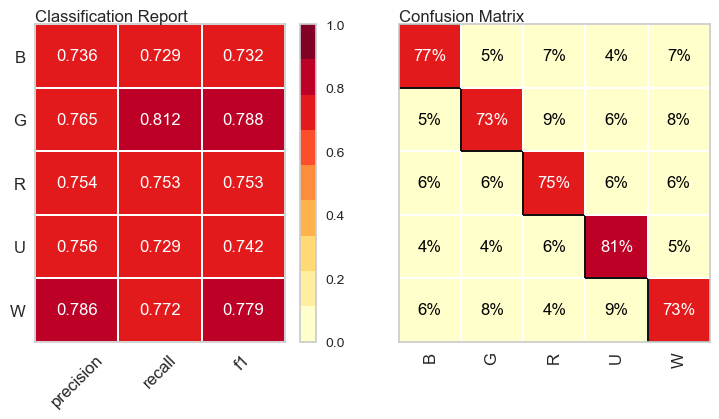

In [54]:
fig, axs = plt.subplots(ncols=2, figsize=(8,5), sharey=True)

repo_classif = ClassificationReport(
    ax=axs[0], 
    estimator=logit, 
    classes=classy, 
    is_fitted=True
).fit(df_X_train_text, y_train).score(df_X_val_text, y_val)

axs[0].set_title(
    label='Classification Report', 
    loc='left', 
    pad=1
)

cm = ConfusionMatrix(
    ax=axs[1], 
    estimator=logit, 
    classes=classy, 
    fontsize=12, 
    is_fitted=True, 
    percent=True
).fit(df_X_train_text, y_train).score(df_X_val_text, y_val)

axs[1].set_title(
    label='Confusion Matrix', 
    loc='left', 
    pad=1
)

plt.tight_layout(pad=3)
plt.show()

**Feature selection**

*Feature Importances*

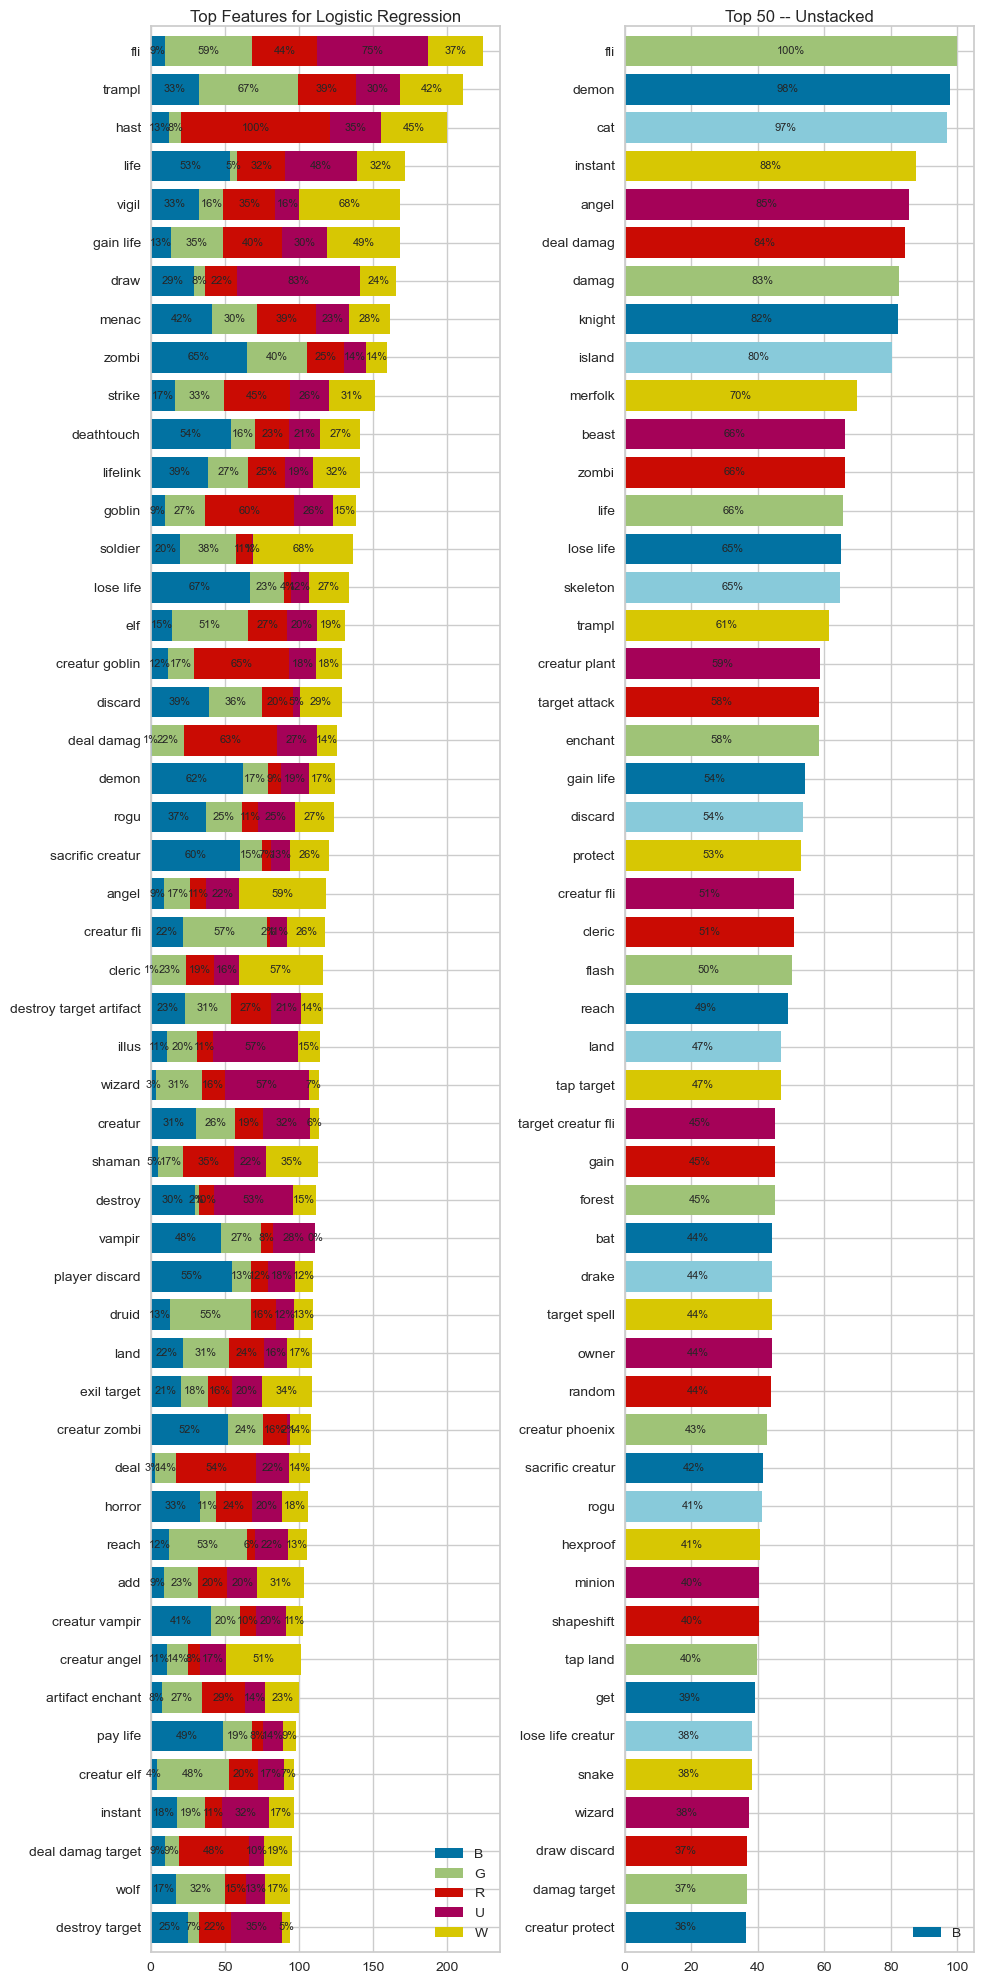

In [55]:
fig9, axs = plt.subplots(ncols=2, figsize=(10, 20))

featImp = FeatureImportances(
    estimator=logit, 
    ax=axs[0], 
    absolute=True, 
    relative=True, 
    stack=True, 
    color=['black','red', 'lime', 'cyan', 'y'], 
    is_fitted=True, 
    labels=tfidf.get_feature_names(), 
    topn=50
).fit(df_X_train_text, y_train)

axs[0].set_title(
    label='Top Features for Logistic Regression', 
    loc='center', 
    pad=3
)

for p in axs[0].patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    axs[0].text(x+width/2, 
    y+height/2, 
    '{:.0f}%'.format(width), 
    horizontalalignment='center', 
    verticalalignment='center', 
    fontsize=8
    )

axs[0].legend(
    labels=classy, 
    loc='best'
)

axs[0].get_figure().tight_layout()
axs[0].margins(y=0.005)

featImp_2 = FeatureImportances(
    estimator=logit, 
    ax=axs[1], 
    absolute=True, 
    relative=True, 
    stack=False, 
    is_fitted=True, 
    labels=tfidf.get_feature_names(), 
    topn=50
).fit(df_X_train_text, y_train)

axs[1].set_title(
    label='Top 50 -- Unstacked', 
    loc='center', 
    pad=3
)

for p in axs[1].patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    axs[1].text(
        x+width/2, 
        y+height/2, 
        '{:.0f}%'.format(width), 
        horizontalalignment='center', 
        verticalalignment='center', 
        fontsize=8
        )

axs[1].legend(
    labels=classy, 
    loc='best'
)

axs[1].get_figure().tight_layout()
axs[1].margins(y=0.005)

fig9.show()

*Recursive Feature Elimination*

KeyboardInterrupt: 

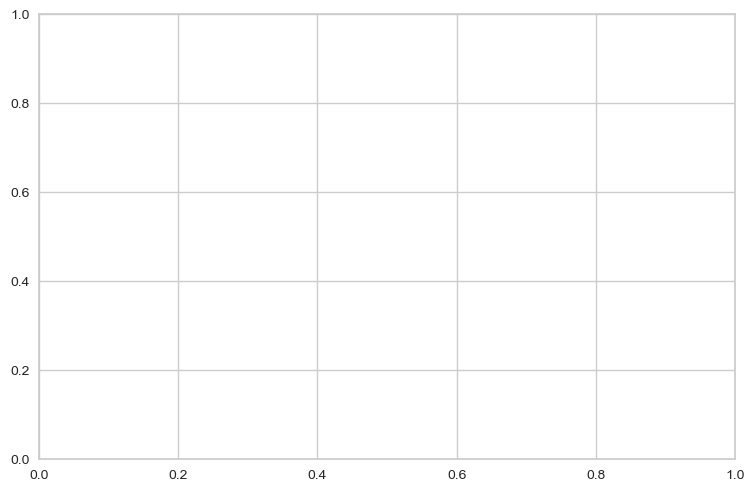

In [56]:
fig10, ax10 = plt.subplots()

rfecv = RFECV(
    logit, 
    ax=ax10, 
    step=300, 
    cv=3
    #scoring='precision'
)

rfecv.fit(df_X_train_text, y_train)

rfecv.show()

*Feature Dropping Curve*

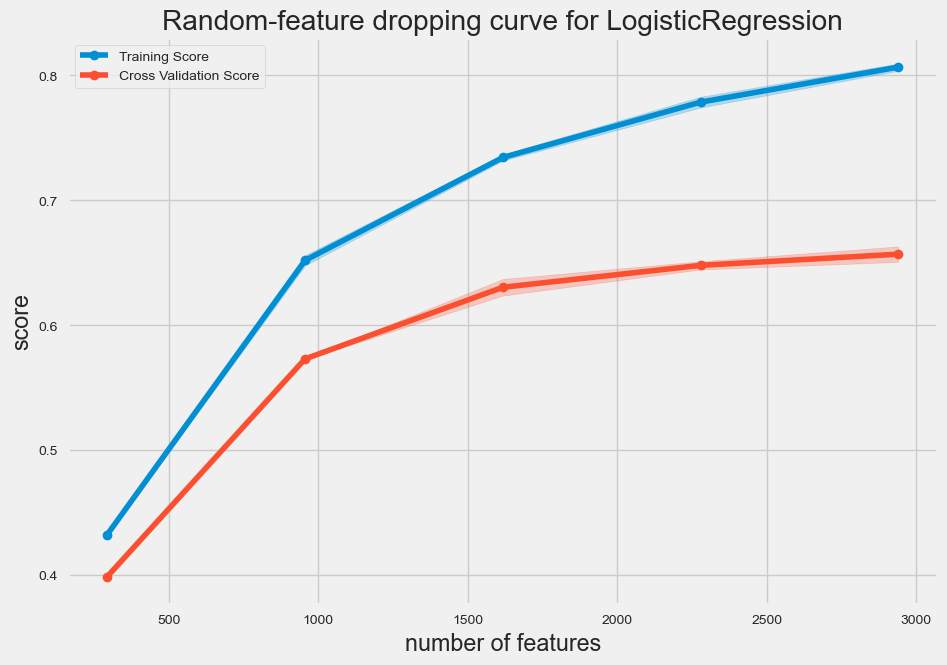

<AxesSubplot:title={'center':'Random-feature dropping curve for LogisticRegression'}, xlabel='number of features', ylabel='score'>

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

dropCurve = DroppingCurve(
    estimator=logit, 
    ax=ax, 
    cv=3, 
    n_jobs=-1, 
    random_state=1
)

dropCurve.fit(df_X_train_text, y_train)

dropCurve.show()

In [ ]:
from sklearn.metrics import precision_score

# Make probabilistic predictions (scores)
y_proba = logit.predict_proba(X_val)[:,3]

# First calculate precision and recall using the default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)
print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_val, y_threshold, average='macro')}")


Threshold of 0.5:
Precision score: 0.052979160969829554


*Validation Curve*

/Users/audreygilbreath/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/audreygilbreath/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

KeyboardInterrupt: 

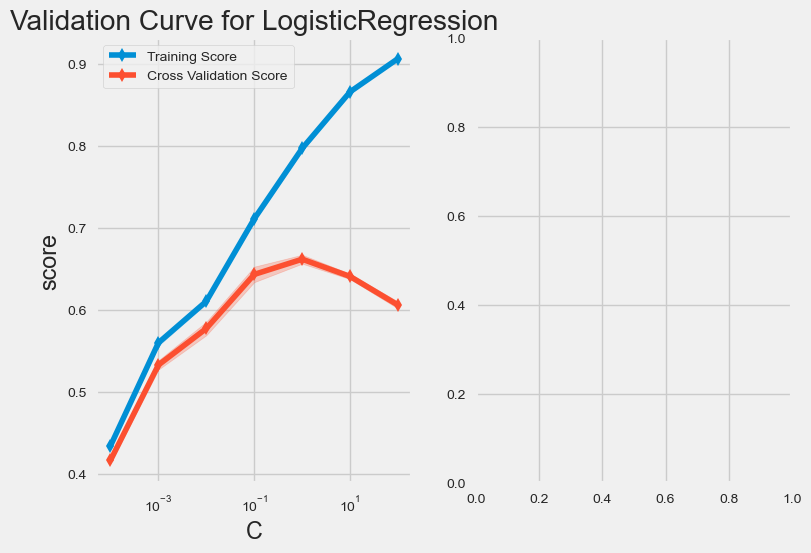

In [ ]:
fig8, ax8 = plt.subplots(ncols=2)

viz_valCurve_1 = ValidationCurve(
    estimator=logit, 
    param_name='C', 
    param_range=[0.0001, 0.001, 0.01,0.1,1,10,100], 
    ax=ax8[0], 
    cv=5, 
    n_jobs=-1, 
    logx=True
)

viz_valCurve_1.fit(df_X_train_mm, y_train)
viz_valCurve_1.finalize()

axs[0].get_figure().tight_layout()
axs[0].margins(y=0.005)

viz_valCurve_2 = ValidationCurve(
    estimator=logit, 
    param_name='solver', 
    param_range=['lbfgs', 'newton-cg', 'sag', 'saga'], 
    ax=ax8[1], 
    cv=5, 
    n_jobs=-1
)

viz_valCurve_2.fit(df_X_train_mm, y_train)
viz_valCurve_2.finalize()

axs[1].get_figure().tight_layout()
axs[1].margins(y=0.005)

plt.show()


**GridSearchCV**

In [57]:
cachedir_1 = mkdtemp()

In [58]:
# Insatiate estimators for pipeline
estimators_1 = [
    ('dim_reduct', TruncatedSVD()),  # Instantiate scaler
    ('model', LogisticRegression())  # Instantiate model
]

# Instantiate pipeline with estimators parameter
pipe_1 = Pipeline(estimators_1) # FIXME: Include memory=cachedir_1 ?

# Instantiate param_grid parameter for GridSearchCV
params_1 = { 
    'dim_reduct': [TruncatedSVD(), None],
    'model': [LogisticRegression(random_state=1, n_jobs=-1, max_iter=800)],
    # Fitting the model using these C-values
    'model__C': [0.0001, 0.001, 0.1, 1, 10],
    'model__multi_class':['ovr'], 
    'model__solver':['lbfgs', 'newton-cg', 'sag', 'saga']
}

# Instantiate GridSearchCV with estimators and param_grid as parameters
grid_1 = GridSearchCV(pipe_1, params_1, verbose=3, n_jobs=-1)

# Fitting the best found model from the gridsearch
fittedgrid_1 = grid_1.fit(df_X_train_text, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 3/5] END dim_reduct=TruncatedSVD(), model=LogisticRegression(max_iter=800, n_jobs=-1, random_state=1), model__C=0.0001, model__multi_class=ovr, model__solver=lbfgs; total time=  11.8s
[CV 4/5] END dim_reduct=TruncatedSVD(), model=LogisticRegression(max_iter=800, n_jobs=-1, random_state=1), model__C=0.0001, model__multi_class=ovr, model__solver=lbfgs; total time=  11.9s
[CV 3/5] END dim_reduct=TruncatedSVD(), model=LogisticRegression(max_iter=800, n_jobs=-1, random_state=1), model__C=0.0001, model__multi_class=ovr, model__solver=newton-cg; total time=  11.6s
[CV 2/5] END dim_reduct=TruncatedSVD(), model=LogisticRegression(max_iter=800, n_jobs=-1, random_state=1), model__C=0.0001, model__multi_class=ovr, model__solver=newton-cg; total time=  11.9s
[CV 1/5] END dim_reduct=TruncatedSVD(), model=LogisticRegression(max_iter=800, n_jobs=-1, random_state=1), model__C=0.0001, model__multi_class=ovr, model__solver=lbfgs; total tim

In [59]:
fittedgrid_1.best_params_

{'dim_reduct': None,
 'model': LogisticRegression(C=10, max_iter=800, multi_class='ovr', n_jobs=-1,
                    random_state=1),
 'model__C': 10,
 'model__multi_class': 'ovr',
 'model__solver': 'lbfgs'}

In [60]:
fittedgrid_1.best_score_

0.7503115765950715

#### **Random Forest**

**Baseline**

In [61]:
rf = RandomForestClassifier(
    max_depth=1, 
    n_jobs=-1, 
    random_state=1
)

rf.fit(df_X_train_text, y_train)

print(f"train score: {rf.score(df_X_train_text, y_train)} \n ")
print(f"val score: {rf.score(df_X_val_text, y_val)}")

train score: 0.5166923472008218 
 
val score: 0.5188201628879595


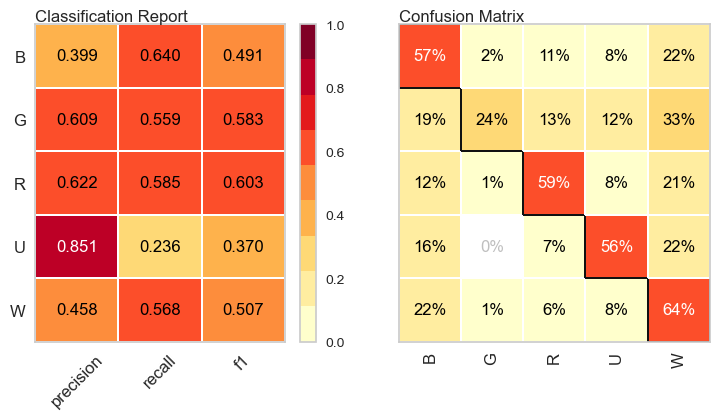

In [62]:
fig, axs = plt.subplots(ncols=2, figsize=(8,5), sharey=True)

repo_classif = ClassificationReport(
    ax=axs[0], 
    estimator=rf, 
    classes=classy, 
    is_fitted=True
).fit(df_X_train_text, y_train).score(df_X_val_text, y_val)

axs[0].set_title(
    label='Classification Report', 
    loc='left', 
    pad=1
)

cm = ConfusionMatrix(
    ax=axs[1], 
    estimator=rf, 
    classes=classy, 
    fontsize=12, 
    is_fitted=True, 
    percent=True
).fit(df_X_train_text, y_train).score(df_X_val_text, y_val)

axs[1].set_title(
    label='Confusion Matrix', 
    loc='left', 
    pad=1
)

plt.tight_layout(pad=3)
plt.show()

In [63]:
# Insatiate estimators for pipeline
estimators_2 = [
    ('dim_reduct', TruncatedSVD()), 
    ('model', RandomForestClassifier())  # Instantiate model
]

# Instantiate pipeline with estimators parameter
pipe_2 = Pipeline(estimators_2) # FIXME: Include memory=cachedir_1 ?

# Instantiate param_grid parameter for GridSearchCV
params_2 = { 
    'dim_reduct': [TruncatedSVD(), None],
    'model': [RandomForestClassifier(random_state=1, n_jobs=-1)],
    # Fitting the model using these C-values
    'model__max_depth': [2, 10, 50, 100, 250],
    'model__n_estimators':[10, 100, 250, 500], 
    'model__criterion':['gini', 'entropy'], 
    'model__max_features':['sqrt', 'log2']
}

# Instantiate GridSearchCV with estimators and param_grid as parameters
grid_2 = GridSearchCV(pipe_2, params_2, verbose=3, n_jobs=-1)

# Fitting the best found model from the gridsearch
fittedgrid_2 = grid_2.fit(df_X_train_text, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV 2/5] END dim_reduct=TruncatedSVD(), model=RandomForestClassifier(n_jobs=-1, random_state=1), model__criterion=gini, model__max_depth=2, model__max_features=sqrt, model__n_estimators=10; total time=   4.1s
[CV 1/5] END dim_reduct=TruncatedSVD(), model=RandomForestClassifier(n_jobs=-1, random_state=1), model__criterion=gini, model__max_depth=2, model__max_features=sqrt, model__n_estimators=10; total time=   4.3s
[CV 4/5] END dim_reduct=TruncatedSVD(), model=RandomForestClassifier(n_jobs=-1, random_state=1), model__criterion=gini, model__max_depth=2, model__max_features=sqrt, model__n_estimators=100; total time=   8.7s
[CV 3/5] END dim_reduct=TruncatedSVD(), model=RandomForestClassifier(n_jobs=-1, random_state=1), model__criterion=gini, model__max_depth=2, model__max_features=sqrt, model__n_estimators=10; total time=   9.4s
[CV 5/5] END dim_reduct=TruncatedSVD(), model=RandomForestClassifier(n_jobs=-1, random_state=1), mod

*Validation curve*

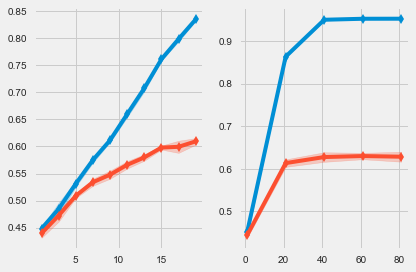

In [ ]:
fig_7, ax_7 = plt.subplots(ncols=2)

viz_valCurve_1 = ValidationCurve(
    estimator=RandomForestClassifier(), 
    param_name='max_depth', 
    param_range=np.arange(1,21, 2), 
    ax=ax_7[0], 
    cv=5, 
    n_jobs=-1
).fit(df_X_train_mm, y_train)

viz_valCurve_2 = ValidationCurve(
    estimator=RandomForestClassifier(), 
    param_name='max_depth', 
    param_range=np.arange(1,101, 20), 
    ax=ax_7[1], 
    cv=5, 
    n_jobs=-1
).fit(df_X_train_mm, y_train)

plt.tight_layout()
plt.show()

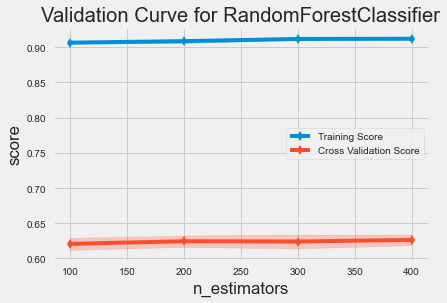

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='n_estimators', ylabel='score'>

In [ ]:
fig7, ax7 = plt.subplots()

viz_valCurve = ValidationCurve(
    estimator=RandomForestClassifier(max_depth=25), 
    param_name='n_estimators', 
    param_range=np.arange(100, 401, 100), 
    ax=ax7, 
    cv=5, 
    n_jobs=-1
)

viz_valCurve.fit(df_X_train_mm, y_train)

viz_valCurve.show()

In [64]:
fittedgrid_2.best_score_

0.722503651551152